In [1]:
# Set the matplotlib backend and make the plots a bit bigger
%matplotlib inline
import seaborn as sns
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 6]
matplotlib.rc('text', usetex = True)

import sys
#sys.path.insert(0,os.path.expanduser("~/g2full/GSASII/"))
#import GSASIIscriptable as G2sc

import re
from lmfit.models import GaussianModel, PolynomialModel, LorentzianModel, ExponentialModel, LinearModel
from lmfit import Parameters, fit_report, minimize, Model
from lmfit.model import save_modelresult, load_modelresult

import pandas as pd

import pyFAI
import numpy as np
import imageio
import matplotlib.pyplot as plt
sys.path.append("../../src/diamond_analysis")
sys.path.append("../../src/xrd")

from load_data import list_runs, load_tiff
from integrate_quads import integrate1d, integrate2d
from combine_quads import merge_four_quads, peaks_from_file, combine_patterns
from peak_shapes import *
quad_scale = np.loadtxt("../../.data_LW03/instprm/quad_scale_LW03.txt")

import logging
from stipcrawl import setup_logger
logger = setup_logger.logger

wavelength = 1.3051 * 10e-10

### This notebook makes use of the pyFAI package to azimuthaly integrate XRD spectra. 
Documentation of the package can be found [here](https://pyfai.readthedocs.io/en/master/index.html)

In [2]:
# define the data directory
dir_data = "../../.data_LW03"

# the logbook file
logbook = "../../.data_LW03/logbook_LW03_subset.ods"

# the calibration .poni files created by Dioptas
poni_file_q0 = "../../.data_LW03/poni/Quad0_CeO2.poni"
poni_file_q1 = "../../.data_LW03/poni/Quad1_CeO2.poni"
poni_file_q2 = "../../.data_LW03/poni/Quad2_CeO2.poni"
poni_file_q3 = "../../.data_LW03/poni/Quad3_CeO2.poni"

poni_file_q0 = "../../.data_LW03/poni/Quad0_MS.poni"
poni_file_q1 = "../../.data_LW03/poni/Quad1_MS.poni"
poni_file_q2 = "../../.data_LW03/poni/Quad2_MS.poni"
poni_file_q3 = "../../.data_LW03/poni/Quad3_MS.poni"

# the mask files for the quad detectors
mask_q0 = "../../.data_LW03/mask/Quad0_ext.mask"
mask_q1 = "../../.data_LW03/mask/Quad1_ext.mask"
mask_q2 = "../../.data_LW03/mask/Quad2.mask"
mask_q3 = "../../.data_LW03/mask/Quad3.mask"

# define the pattern for a background file
pattern_runs = re.compile("r[0-9]*_bkgCorrected")

# define the azimuthal intyegrator objects from pyFAI
q0_ai = pyFAI.load(poni_file_q0)
q1_ai = pyFAI.load(poni_file_q1)
q2_ai = pyFAI.load(poni_file_q2)
q3_ai = pyFAI.load(poni_file_q3)

# load the masks as np arrays

q0_mask = np.array(imageio.imread(mask_q0),dtype=int)
q1_mask = np.array(imageio.imread(mask_q1),dtype=int)
q2_mask = np.array(imageio.imread(mask_q2),dtype=int)
q3_mask = np.array(imageio.imread(mask_q3),dtype=int)


DRM_IOCTL_I915_GEM_APERTURE failed: Invalid argument
Assuming 131072kB available aperture size.
May lead to reduced performance or incorrect rendering.
get chip id failed: -1 [2]
param: 4, val: 0
DRM_IOCTL_I915_GEM_APERTURE failed: Invalid argument
Assuming 131072kB available aperture size.
May lead to reduced performance or incorrect rendering.
get chip id failed: -1 [2]
param: 4, val: 0
beignet-opencl-icd: no supported GPU found, this is probably the wrong opencl-icd package for this hardware
(If you have multiple ICDs installed and OpenCL works, you can ignore this message)


In [3]:
r182_q0_tiff = load_tiff(182, 0, dir_data)
r182_q1_tiff = load_tiff(182, 1, dir_data)
r182_q2_tiff = load_tiff(182, 2, dir_data)
r182_q3_tiff = load_tiff(182, 3, dir_data)

r182_q0_result1d = q0_ai.integrate1d(r182_q0_tiff,
                    npt=1000,
                    method='csr',
                    unit='2th_deg',
                    correctSolidAngle=True,
                    polarization_factor=0.99,
                    mask=q0_mask)

r182_q1_result1d = q1_ai.integrate1d(r182_q1_tiff,
                    npt=1000,
                    method='csr',
                    unit='2th_deg',
                    correctSolidAngle=True,
                    polarization_factor=0.99,
                    mask=q1_mask)
r182_q2_result1d = q2_ai.integrate1d(r182_q2_tiff,
                    npt=1000,
                    method='csr',
                    unit='2th_deg',
                    correctSolidAngle=True,
                    polarization_factor=0.99,
                    mask=q2_mask)
r182_q3_result1d = q3_ai.integrate1d(r182_q3_tiff,
                    npt=1000,
                    method='csr',
                    unit='2th_deg',
                    correctSolidAngle=True,
                    polarization_factor=-0.99,
                    mask=q3_mask)

In [4]:
def merge_quad23(run, dir_data, q2_ai, q3_ai,q2_mask,q3_mask):
    r_q2_tiff = load_tiff(run, 2, dir_data)
    r_q3_tiff = load_tiff(run, 3, dir_data)
    r_q2_result1d = q2_ai.integrate1d(r_q2_tiff,
                    npt=1000,
                    method='csr',
                    unit='2th_deg',
                    correctSolidAngle=True,
                    polarization_factor=0.99,
                    mask=q2_mask)
    r_q3_result1d = q3_ai.integrate1d(r_q3_tiff,
                    npt=1000,
                    method='csr',
                    unit='2th_deg',
                    correctSolidAngle=True,
                    polarization_factor=-0.99,
                    mask=q3_mask)
    #plt.plot(r_q2_result1d[0],r_q2_result1d[1]*quad_scale[3])
    #plt.plot(r_q3_result1d[0],r_q3_result1d[1]*quad_scale[2])

    merged_xy = merge_four_quads([np.array(r_q2_result1d),np.array(r_q3_result1d)], scale=[quad_scale[3],quad_scale[2]])

    #plt.plot(merged_xy[0],merged_xy[1])
    #plt.show()
    np.savetxt(f"../../.data_LW03/lineouts/r{run}_Q23.xy",merged_xy.T)
runs = [182,186,188,190,192,289]
probing_times = np.array([9.,8.,7.,10.,11.,13.])
for run in runs:
    merge_quad23(run,dir_data, q2_ai, q3_ai,q2_mask,q3_mask)

Shape of quad 0 is (2, 1000)
Shape of quad 1 is (2, 1000)
Combined data: (2, 1000) tmp: (2, 1000)
Quad_A going from : 21.125430507995922 to 61.46693138930832 
Quad_B going from : 40.59532307444896 to 72.32085688075271 
Shape of quad 0 is (2, 1000)
Shape of quad 1 is (2, 1000)
Combined data: (2, 1000) tmp: (2, 1000)
Quad_A going from : 21.125430507995922 to 61.46693138930832 
Quad_B going from : 40.59532307444896 to 72.32085688075271 
Shape of quad 0 is (2, 1000)
Shape of quad 1 is (2, 1000)
Combined data: (2, 1000) tmp: (2, 1000)
Quad_A going from : 21.125430507995922 to 61.46693138930832 
Quad_B going from : 40.59532307444896 to 72.32085688075271 
Shape of quad 0 is (2, 1000)
Shape of quad 1 is (2, 1000)
Combined data: (2, 1000) tmp: (2, 1000)
Quad_A going from : 21.125430507995922 to 61.46693138930832 
Quad_B going from : 40.59532307444896 to 72.32085688075271 
Shape of quad 0 is (2, 1000)
Shape of quad 1 is (2, 1000)
Combined data: (2, 1000) tmp: (2, 1000)
Quad_A going from : 21.125

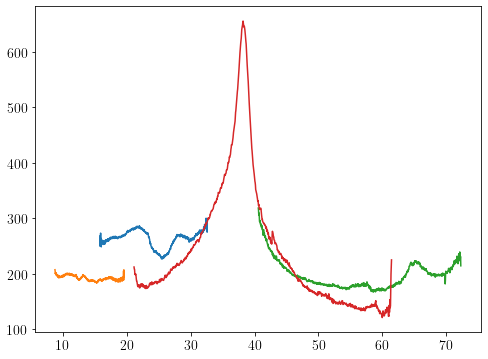

In [5]:
plt.plot(r182_q0_result1d[0],r182_q0_result1d[1]*quad_scale[1]/quad_scale[1])
plt.plot(r182_q1_result1d[0],r182_q1_result1d[1]*quad_scale[0]/quad_scale[0])
plt.plot(r182_q2_result1d[0],r182_q2_result1d[1]*quad_scale[3]/quad_scale[3])
plt.plot(r182_q3_result1d[0],r182_q3_result1d[1]*quad_scale[2]/quad_scale[2])

In [6]:
run_182 = integrate1d(182,3,dir_data,poni_file_q3,q3_mask)
file_name = 'tmp.xy'
np.savetxt(file_name,run_182.T)
print(run_182.T)

inst_file = '../../.data_LW03/instprm/LW03.instprm'
cif_file = '../../.data_LW03/cif/diamond.cif'

[[ 17.64958335 212.27613831]
 [ 17.68117096 208.01829529]
 [ 17.71275857 208.93417358]
 ...
 [ 49.14243036 172.15136719]
 [ 49.17401797 184.99255371]
 [ 49.20560558 196.0697937 ]]


In [7]:
r182_q2 = np.loadtxt("../../.data_LW03/lineouts/r182_Q2.xy").T
r182_q3 = np.loadtxt("../../.data_LW03/lineouts/r182_Q3.xy").T
merged_xy = merge_four_quads([np.array(r182_q2_result1d),np.array(r182_q3_result1d)],scale=[quad_scale[2],quad_scale[3]])
#merged_xy = merge_four_quads([np.array(r182_q0_result1d),np.array(r182_q1_result1d),np.array(r182_q2_result1d),np.array(r182_q3_result1d)],scale=quad_scale)
r182_Q23 = np.loadtxt("../../.data_LW03/lineouts/r182_Q23.xy").T

Shape of quad 0 is (2, 1000)
Shape of quad 1 is (2, 1000)
Combined data: (2, 1000) tmp: (2, 1000)
Quad_A going from : 21.125430507995922 to 61.46693138930832 
Quad_B going from : 40.59532307444896 to 72.32085688075271 


In [8]:
def residual(pars, x, data=None, eps=None):
    # unpack parameters: extract .value attribute for each parameter
    parvals     = pars.valuesdict()
    slope       = parvals['scale']
    intercept   = parvals['intercept']
    amp_gauss   = parvals['amp_gauss']
    cen_gauss   = parvals['cen_gauss']
    wid_gauss   = parvals['wid_gauss']
    amp_lor     = parvals['amp_lor'] 
    cen_lor     = parvals['cen_lor']
    wid_lor     = parvals['wid_lor']
    amp_lor2    = parvals['amp_lor2']
    cen_lor2    = parvals['cen_lor2']
    wid_lor2    = parvals['wid_lor2']

    model = lin_gauss_2lorentzian(x, slope,intercept,amp_gauss, cen_gauss, wid_gauss, amp_lor, cen_lor, wid_lor, amp_lor2, cen_lor2, wid_lor2)

    if data is None:
        return model
    if eps is None:
        return (model - data)
    return (model-data) / eps

In [9]:
def fit_double_peak(data):
    twoTheta, I = data[0], data[1]
    fit_params          = Parameters()
    fit_params.add('scale', value=0.01)
    fit_params.add('intercept', value=200.)
    fit_params.add('amp_gauss', value=1.)
    fit_params.add('cen_gauss', value=30.9)
    fit_params.add('wid_gauss', value=0.9)
    fit_params.add('amp_lor', value=0.9)
    fit_params.add('cen_lor', value=37.)
    fit_params.add('wid_lor', value=0.9)
    fit_params.add('amp_lor2', value=66.)
    fit_params.add('cen_lor2', value=0.9)
    fit_params.add('wid_lor2', value=0.9)
    

    out                 = minimize(residual, fit_params, args=(twoTheta,), kws={'data': I});
    param_dict          = out.params.valuesdict()
    return out, param_dict

In [10]:
def fit_diamond(data, plot=False):

    background = PolynomialModel(degree=7, prefix='bkg_')
    pars = background.guess(data[1], x=data[0])

    pars['bkg_c0'].set(value=np.random.normal(15000.,1000))
    pars['bkg_c1'].set(value=np.random.normal(-2500,1000))
    pars['bkg_c2'].set(value=np.random.normal(143,500))
    pars['bkg_c3'].set(value=np.random.normal(-4,5))
    pars['bkg_c4'].set(value=np.random.normal(0.06,0.005))
    pars['bkg_c5'].set(value=np.random.normal(-0.0005,5e-4))
    pars['bkg_c6'].set(value=np.random.normal(2.0e-06,5e-6))
    pars['bkg_c7'].set(value=np.random.normal(2.0e-06,5e-6))

    peak1 = LorentzianModel(prefix='C111_')
    pars.update(peak1.make_params())

    pars['C111_center'].set(value=39, min=30, max=40)
    pars['C111_sigma'].set(value=np.random.normal(2.22,0.5))
    pars['C111_amplitude'].set(value=np.random.normal(3143,50))

    peak2 = LorentzianModel(prefix='C220_')
    pars.update(peak2.make_params())

    pars['C220_center'].set(value=63.9, min=60, max=67)
    pars['C220_sigma'].set(value=2.5, max=3.7)
    pars['C220_amplitude'].set(value=np.random.normal(1000,50), min=0.)

    PET_peak = LorentzianModel(prefix='PET_')
    pars.update(PET_peak.make_params())

    pars['PET_center'].set(value=27, min=26, max=29.)
    pars['PET_sigma'].set(value=1.5, max=2.5)
    pars['PET_amplitude'].set(value=np.random.normal(1000,50), min=0.)

    model = peak1 + peak2 + background + PET_peak

    init = model.eval(pars, x=data[0])
    out = model.fit(data[1], pars, x=data[0])
    #print(result.fit_report())

    # print(out.fit_report)
    if plot==True:

        fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
        axes[0].plot(data[0], data[1],label='XRD data')
        #axes[0].plot(data[0], init, '--', label='initial fit')
        axes[0].plot(data[0], out.best_fit, '-', label='best fit')
        axes[0].set_ylabel(r'$I$')
        axes[0].set_xlabel(r'$2\theta$')
        axes[0].legend()

        comps = out.eval_components(x=data[0])
        #print(out.params.valuesdict())

        axes[1].plot(data[0], data[1])
        axes[1].plot(data[0], comps['C111_'], '--', label='Peak 111')
        axes[1].plot(data[0], comps['C220_'], '--', label='Peak 220')
        axes[1].plot(data[0], comps['bkg_'], '--', label='Background')
        axes[1].plot(data[0], comps['PET_'], '--', label='PET peak')
        #axes[1].set_ylabel(r'$I [au]$')
        axes[1].set_xlabel(r'$2\theta$')
        axes[1].legend()

        plt.show() 

    else:
        fig = None
    return out, fig


In [11]:
def init_fits(runs=[182,186,188,190,192]):
    ### fit all runs and store the optimied models in files ###
    fits        = [[]] * len(runs)
    
    for run_id, run in enumerate(runs):
        data                    = np.loadtxt(f"../../.data_LW03/lineouts/r{run}_Q23.xy").T
        fits[run_id], fig       = fit_diamond(data)
        #fig.savefig(f'../../.data_LW03/figures/r{run}__fit_plot.svg')
        save_modelresult(fits[run_id], f'../../.data_LW03/fits/r{run}__modelresult.sav')

In [12]:
def sampleChi2(runs=[182,186,188,190,192],rounds=10):
    ### run a routine to fit and only store if the Chi2 of the fit is better ###
    fits        = [[]] * len(runs)

    # repeat fitting with random inital parameters and overwrite if the fit is better 
    for i in range(rounds):
        for run_id, run in enumerate(runs):
                data                = np.loadtxt(f"../../.data_LW03/lineouts/r{run}_Q23.xy").T
                fits[run_id]        = load_modelresult( f'../../.data_LW03/fits/r{run}__modelresult.sav')
                new_fit, fig        = fit_diamond(data)
                if new_fit.chisqr < fits[run_id].chisqr:
                    old_chi      = fits[run_id].chisqr
                    fits[run_id] = new_fit
                    save_modelresult(fits[run_id], f'../../.data_LW03/fits/r{run}__modelresult.sav')
                    print(f"Old Chi2 is {old_chi} new Chi2 is {new_fit.chisqr}")

In [13]:
def plotBestFits(runs=[182,186,188,190,192]):
    fits            = [[]] * len(runs)
    fig             = plt.figure(figsize=(12, 16))
    gs              = fig.add_gridspec(len(runs)*3, 2)
    probingTime     = {182:9.,186:8.,188:7.,190:10.,192:11.}

    for run_id, run in enumerate(runs):
        data                = np.loadtxt(f"../../.data_LW03/lineouts/r{run}_Q23.xy").T
        fits[run_id]        = load_modelresult( f'../../.data_LW03/fits/r{run}__modelresult.sav')

        t                   = int(probingTime[run])
        t_id                = (int(t-np.min(list(probingTime.values()))))
        comps               = fits[run_id].eval_components(x=data[0])
        #print(out.params.valuesdict())
        ax1                 = fig.add_subplot(gs[t_id*3:t_id*3+2, 0:0+1])

        ax1.plot(data[0], data[1],label='XRD data')
        #axes[0].plot(data[0], init, '--', label='initial fit')
        ax1.plot(data[0], fits[run_id].best_fit, '-', label='best fit')
        ax1.set_ylabel(r'$I$ [\textit{au}]',fontsize=20)
        if run_id == len(runs)-1:
            ax1.set_xlabel(r'$2\theta$ [\textit{deg}]',fontsize=20)
        #axes[t_id,0].plot(data[0], comps['bkg_'], '--', label='Background',color='r')
        ax1.legend()
        ax1.axes.yaxis.set_ticks([])
        
        ax2                 = fig.add_subplot(gs[t_id*3:t_id*3+3, 1:1+1])
        ax2.plot(data[0], data[1])
        ax2.plot(data[0], comps['C111_'], '--', label='Peak 111')
        ax2.plot(data[0], comps['C220_'], '--', label='Peak 220')
        ax2.plot(data[0], comps['bkg_'], '--', label='Background')
        ax2.plot(data[0], comps['PET_'], '--', label='PET peak')
        ax2.axes.yaxis.set_ticks([])
        #axes[1].set_ylabel(r'$I [au]$')
        if run_id == len(runs)-1:
            ax2.set_xlabel(r'$2\theta$ [\textit{deg}]',fontsize=20)
        ax2.legend()

        ax3                 = fig.add_subplot(gs[t_id*3+2:t_id*3+3, 0:0+1])
        residuals           = (fits[run_id].best_fit - data[1])/np.max(data[1])
        ax3.plot(data[0],residuals)
    fig.savefig(f'../../.data_LW03/figures/bestFits.svg')
    plt.show() 


In [14]:
#init_fits(runs=[182,186])
#sampleChi2(runs=[182,186],rounds=5)

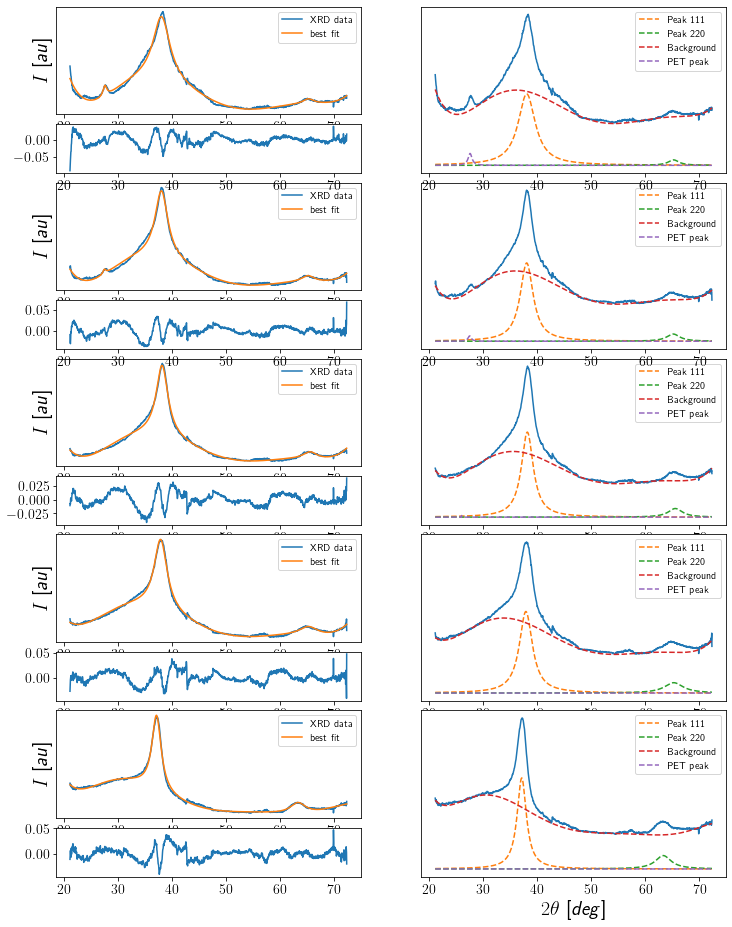

In [15]:
plotBestFits()

In [16]:
neus_r182           = np.loadtxt("../../.data_LW03/VISAR/Visar_v2_r182.txt")
time_r182           = neus_r182[:,0]
v2_r182             = neus_r182[:,1]

In [184]:
def waterfallPlot(runs=[182,186,188,190,192],fig = None, axes = None):
    if fig == None:
        fig, axes       = plt.subplots(figsize=(8, 7))
    probingTime     = {182:9.,186:8.,188:7.,190:10.,192:11.}
    fits            = [[]] * len(runs)
    colors = ['gold','deepskyblue','deeppink','darkgreen','darkred']
    peak_positions, scaled_int  = peaks_from_file('../../.data_LW03/cif/diamond.txt')
    axes.axvline(x = peak_positions[0], color = 'k',linestyle='dashed',linewidth=0.9)
    axes.axvline(x = peak_positions[3], color = 'k',linestyle='dashed',linewidth=0.9)
    #labels = ['7ns','8ns','9ns','10ns','11ns']

    for run_id, run in enumerate(runs):
        fits[run_id]        = load_modelresult( f'../../.data_LW03/fits/r{run}__modelresult.sav')
        

        t                   = int(probingTime[run])
        t_id                = (int(t-np.min(list(probingTime.values()))))
        data                = np.loadtxt(f"../../.data_LW03/lineouts/r{run}_Q23.xy").T
        comps = fits[run_id].eval_components(x=data[0])

        axes.plot(data[0], data[1]/np.max(data[1]) - t_id,color=colors[t_id], label=f'{t} ns')
        #axes.plot(data[0], comps['C111_']/np.max(data[1]) - t_id, '--', label='Peak 111',c='r')
        #axes.plot(data[0], comps['C220_']/np.max(data[1]) - t_id, '--', label='Peak 220',c='b')
        axes.plot(data[0], comps['bkg_']/np.max(data[1]) - t_id, '--',c='r',linewidth=0.9)
        #axes.plot(data[0], comps['PET_']/np.max(data[1]) - t_id, '--', label='PET peak',c='grey')
        ypos    = (data[1]/np.max(data[1]) - t_id)[-1] + 0.2
        xpos    = 70.
        axes.text(xpos, ypos, f'{t} ns', horizontalalignment='center',verticalalignment='center',fontsize=22,color=colors[t_id])
        
    axes.tick_params(left=False, labelleft=False)
    axes.set_ylabel(r'I [\textit{au}]',fontsize=22)
    axes.set_xlabel(r'Scattering angle $2\theta$ [\textit{deg}]',fontsize=22)
    #axes.spines['bottom'].set_color('white')
    axes.spines['top'].set_color('white') 
    axes.spines['right'].set_color('white')
    #axes.spines['left'].set_color('white')
    axes.xaxis.set_tick_params(labelsize=25)
    axes.yaxis.set_tick_params(labelsize=25)
    axes.text(peak_positions[0]+0.5, 1.2, f'(111) Peak', horizontalalignment='left',verticalalignment='center',fontsize=20,color='k')
    axes.text(peak_positions[3]+0.5, 1.2, f'(200) Peak', horizontalalignment='left',verticalalignment='center',fontsize=20,color='k')
    axes.text(27.55-0.2, 1.2, f'Cold\nPET Peak', horizontalalignment='right',verticalalignment='center',fontsize=20,color='k')
    #plt.savefig('../../.data_LW03/figures/waterfall.pdf')
    #matplotlib.rcParams['figure.figsize'] = [8, 6]
    matplotlib.rc('text', usetex = True)
    axes.axvline(x = 27.55,ymin=0.62, color = 'k',linestyle='dashed',linewidth=0.9)

    #import tikzplotlib
    #tikzplotlib.save('/home/benjamin/Nextcloud/Work/W_PhD/W_PhD_Articles/Heuser_ND_recovery/figures/waterfall.tex')
    #tikzplotlib.get_tikz_code(figure='gcf',filepath="waterfall.tex",override_externals=True)#,strict=True,wrap=False)
    #matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.savefig('/home/benjamin/Nextcloud/Work/W_PhD/W_PhD_Articles/Heuser_ND_recovery/figures/waterfall.pdf')
    plt.show()

In [185]:
visar_path = "/home/benjamin/Nextcloud/Work/W_PhD/W_PhD_Git/PhD_Thesis/.data_LW03/VISAR/"

In [186]:
def load_visar(run : int, visar_path : str, sweep : float) -> [np.array, np.array, np.array, np.array]:
    """
    :param run:         number of the run to load the VISAR data for
    :param visar_path:  path of the location of VISAR raw image and txt data
    :param sweep:       sweep time of the streak camera
    :return:            V1 the image arrays of the VISAR images
    :return:            lineout, time, velocity, vel_err
    """
    file_name_raw = "r" + str(run) + "_V1.tif"
    file_name_txt = "Visar_v1_r" + str(run) + ".txt"
    logger.debug(f"Trying to load raw data at: \nV1: {visar_path + file_name_raw}")
    try:
        V = plt.imread(visar_path + file_name_raw)
        logger.info(f"Loading raw data successful")
    except:
        logger.error(f"Apparently no VISAR raw data in {visar_path}")
        return None, None
    try:
        data = np.loadtxt(visar_path + file_name_txt)
        logger.info(f"Loading Neutrino data successful")
    except:
        logger.error(f"Apparently no Neutrino data in {visar_path}")
        return None, None
    ### Do the vertical lineouts
    lineout = np.sum(V,axis=1)

    ### set the time and v/v_err data
    time = data[:,0]
    velocity = data[:,1]
    vel_err = data[:,2]
    return V, lineout, time, velocity, vel_err

[~]  Loading raw data successful
INFO:stipcrawl.setup_logger:Loading raw data successful
[~]  Loading Neutrino data successful
INFO:stipcrawl.setup_logger:Loading Neutrino data successful


[]

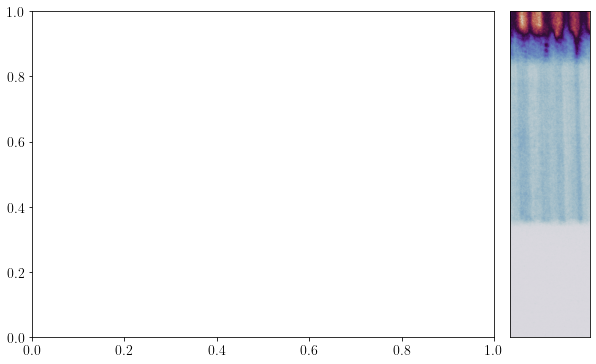

In [187]:
logger.setLevel(logging.INFO)
V182, LO, t_r182, v_r18, v_err_r1822  = load_visar(182,visar_path,20.)
ROI                         = V182[:,550:800]

#time = np.linspace(0,20.,len(LO_1))
fig                         = plt.figure(figsize=(10,6))
gs                          = fig.add_gridspec(1, 6)

ax0                         = fig.add_subplot(gs[0:1, 0:5])
ax1                         = fig.add_subplot(gs[0:1, 5:6])
ax1.imshow(ROI,cmap="twilight")
ax1.set_xticks([])
ax1.set_yticks([])
#axarr[0,1].imshow(V190_2)
#axarr[1,0].plot(time, LO_1)
#axarr[1,1].plot(time, LO_2)
#plt.show()

In [188]:
t_r182[-1] - t_r182[0]

19.375999999999998

In [189]:
t_r182[0]

-2.97

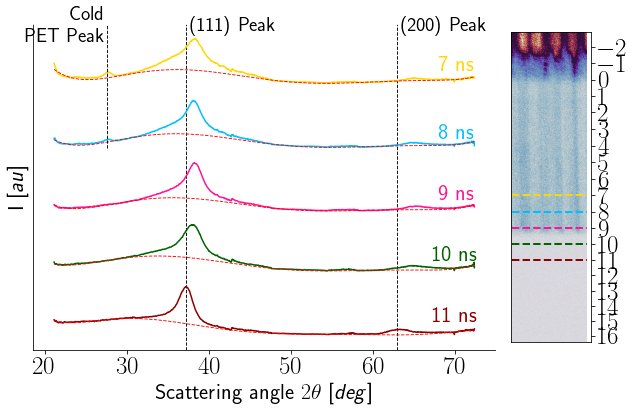

In [190]:
from scipy.interpolate import interp1d
matplotlib.rc('font', weight='bold')

fig                         = plt.figure(figsize=(10,6))
gs                          = fig.add_gridspec(1, 6)

ax0                         = fig.add_subplot(gs[0:1, 0:5])
ax1                         = fig.add_subplot(gs[0:1, 5:6])
ax1.imshow((ROI),cmap="twilight",interpolation='nearest')
ax1.set_xticks([])
#line                        = matplotlib.lines.Line2D([0,1],[0,1],marker=">")

ticksPos                       = np.arange(len(t_r182))
### interpolate to map y values postions to the corresponding tick position
labelMapper                    = interp1d(t_r182, ticksPos)

### get the positions of where we have integer values for the y value
tMin, tMax                     = int(t_r182.min()), int(t_r182.max())
tickLables                     = np.arange(tMin,tMax+1)

#polynomial                     = np.poly1d([-2.,1.52475e-02,9.14541e-06,-5.96076e-09])

tickPositions = [labelMapper(y_value) for y_value in tickLables] 
ax1.set_yticks(tickPositions)
ax1.set_yticklabels([f"${label}$" for label in tickLables],ha='left')
ax1.yaxis.tick_right()
colors = ['gold','deepskyblue','deeppink','darkgreen','darkred']

for id, time in enumerate([7,8,9,10,11]):
        ax1.hlines(y=labelMapper(time), xmin=0, xmax=250, linewidth=2, color=colors[id],linestyle='--')

ax1.yaxis.set_tick_params(labelsize=25)
matplotlib.rc('text', usetex = True)
waterfallPlot(fig=fig,axes=ax0)
ax0.set_yticks([])
fig.tight_layout()
fig.savefig('/home/benjamin/Nextcloud/Work/W_PhD/W_PhD_Articles/Heuser_ND_recovery/figures/waterfall.pdf')

In [130]:
tMin, tMax                     = int(t_r182.min()), int(t_r182.max())
tickLables

array([-2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15])

In [124]:
tMax

16

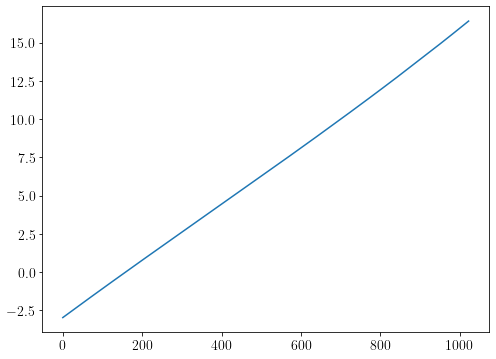

In [103]:
plt.plot(ticksPos,t_r182)

In [25]:
runs                = [182,186,188,190,192,289]
d_111_ambient       = 2.04382 
d_220_ambient       = 1.25158
peak_ratios         = np.zeros(len(runs))
d_C111              = np.zeros(len(runs))
d_C220              = np.zeros(len(runs))
strain_111          = np.zeros(len(runs))
strain_220          = np.zeros(len(runs))

for run_id, run in enumerate(runs):
    result = load_modelresult(f'../../.data_LW03/fits/r{run}__modelresult.sav')
    param_dict              = result.params.valuesdict()
    peak_ratios[run_id]     = param_dict['C220_amplitude'] / param_dict['C111_amplitude']

    d_C111[run_id]          = wavelength / (2. * np.sin( np.deg2rad(param_dict['C111_center'] / 2.)))
    d_C220[run_id]          = wavelength / (2. * np.sin( np.deg2rad(param_dict['C220_center'] / 2.)))

    strain_111[run_id]      = np.abs(d_111_ambient - d_C111[run_id] * 1e9) / d_111_ambient
    strain_220[run_id]      = np.abs(d_220_ambient - d_C220[run_id] * 1e9) / d_220_ambient

    #data            = np.loadtxt(f"../../.data_LW03/lineouts/r{run}_Q23.xy").T
    #fits[run_id]    = fit_diamond(data)
    #save_modelresult(fits[run_id], f'../../.data_LW03/fits/r{run}__modelresult.sav')

In [26]:
d_C111 *1e9

array([1.99600114, 2.00197114, 2.00164662, 2.00967982, 2.04943925,
       2.06805325])

In [27]:
d_C220 * 1e9

array([1.20560174, 1.211755  , 1.21077282, 1.2101689 , 1.24333311,
       1.2438452 ])

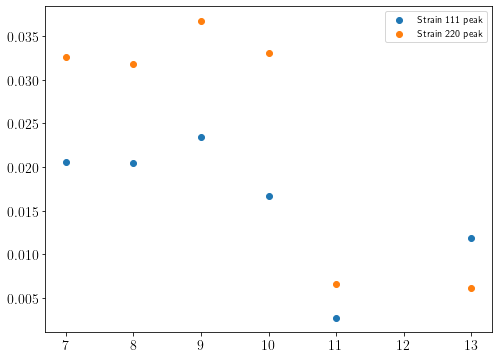

In [28]:
plt.scatter(probing_times, strain_111, label='Strain 111 peak')
plt.scatter(probing_times, strain_220, label='Strain 220 peak')
plt.legend()

In [29]:
peak_positions, scaled_int  = peaks_from_file('../../.data_LW03/cif/diamond.txt')
theoretical_int             = scaled_int[1] / scaled_int[0]
print(theoretical_int)

0.1430697


In [30]:
peak_positions

array([37.23873, 75.37782, 79.36893, 62.84992])

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 24000
    # data points      = 1410
    # variables        = 11
    chi-square         = 504494.671
    reduced chi-square = 360.610916
    Akaike info crit   = 8312.75428
    Bayesian info crit = 8370.51907
##  Warning: uncertainties could not be estimated:
[[Variables]]
    scale:      637.824023 (init = 0.01)
    intercept:  156979.802 (init = 200)
    amp_gauss:  2141.02771 (init = 1)
    cen_gauss:  4126.23892 (init = 30.9)
    wid_gauss: -478.201667 (init = 0.9)
    amp_lor:    2748.98727 (init = 0.9)
    cen_lor:    38.0324274 (init = 37)
    wid_lor:    1.99740541 (init = 0.9)
    amp_lor2:  -1.9648e+08 (init = 66)
    cen_lor2:   191.752195 (init = 0.9)
    wid_lor2:   251.585135 (init = 0.9)


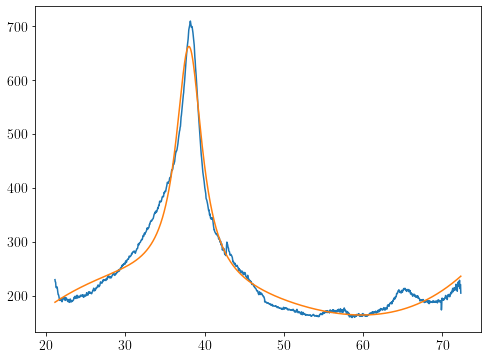

In [31]:
plt.plot(r182_Q23[0],r182_Q23[1])
out, param_dict = fit_double_peak(r182_Q23)
print(fit_report(out))
plt.plot(r182_Q23[0],lin_gauss_2lorentzian(r182_Q23[0],*list(param_dict.values())))

In [32]:
param_dict['scale']

637.82402336744

In [33]:
list(param_dict.values())

[637.82402336744,
 156979.80227212163,
 2141.0277069373356,
 4126.23892070411,
 -478.20166695789516,
 2748.9872692755303,
 38.032427382604126,
 1.9974054079257664,
 -196481521.045302,
 191.75219485409445,
 251.58513512062063]